<font size=6  color=#003366> <div style="text-align: center"> [LGBIO2050] - Medical Imaging <br><br> 
<font size=6  color=#003366> <div style="text-align: center"> Challenge 1 - Heart Beat frequency <br><br> 

<font size=5  color=#003366>
<div style="text-align: left"> Professors :   
<font size=4  color=#003366>
<div style="text-align: left"> Prof. G. Kerckhofs  
<div style="text-align: left"> Prof. J. Lee <br>
<div style="text-align: left"> Prof. B. Macq <br>
<div style="text-align: left"> Prof. F. Peeters
<font size=5  color=#003366>
    
<br> <br>
<div style="text-align: left"> Teaching assistants : 
<font size=4  color=#003366>
<div style="text-align: left"> Damien Dasnoy-Sumell (damien.dasnoy@uclouvain.be)<br> 
<div style="text-align: left">Estelle Loÿen (estelle.loyen@uclouvain.be)
<div style="text-align: left"> Maxence Wynen (maxence.wynen@uclouvain.be)
<font size=5  color=#003366>
<div style="text-align: right"> 2022-2023 </div>
<br><br>
    
</font>
<div style="text-align: left"> Students :
<font size=3  color=#003366>
<div style="text-align: left"> Lorena CLaeys (lorena.claeys@student.uclouvain.be)<br> 
<div style="text-align: left"> Rodin Koffeing (rodin.koffeing@student.uclouvain.be)
<div style="text-align: left"> Colin Gaban (colin.gaban@student.uclouvain.be)
<font size=5  color=#003366>

<font size=6 color=#009999> 1. Guidelines and Deliverables </font> <br> 
   - This assignment is due on **20th October 2022**.
   - Copying code or answers from other groups (or from the internet) is strictly forbidden. Each source of inspiration must be clearly indicated.
   - The jupyter notebook containing the code and **detailed answers** to the questions must be delivered in an
archive (.zip folder) on Moodle. The answers have to be written in English.<br> <br>

<font size=6 color=#009999> 2. Context and objective </font> <br> <br>
<div style="text-align: justify">Along with a good soft tissue contrast, the MRI imaging modality presents the advantage of not giving any imaging
irradiation dose to the patient during the acquisition. It allows to acquire images continuously to observe high
frequency anatomical motions such as breathing, or even faster motion such as coughing or the patient heartbeat.
For this challenge, a 2D dynamic MRI sequence at 20 frames per second is available. The goal is to implement a method
using Fourier transforms to determine the heartbeat frequency of the patient in beats/minute. You will be evaluated
on the robustness of your method and on the heartbeat frequency you find. <br>

The video is a 3D numpy array under the form [t, x, y] where the first component t is the time. You can load it from the file heartVideo.npy using the numpy load function.

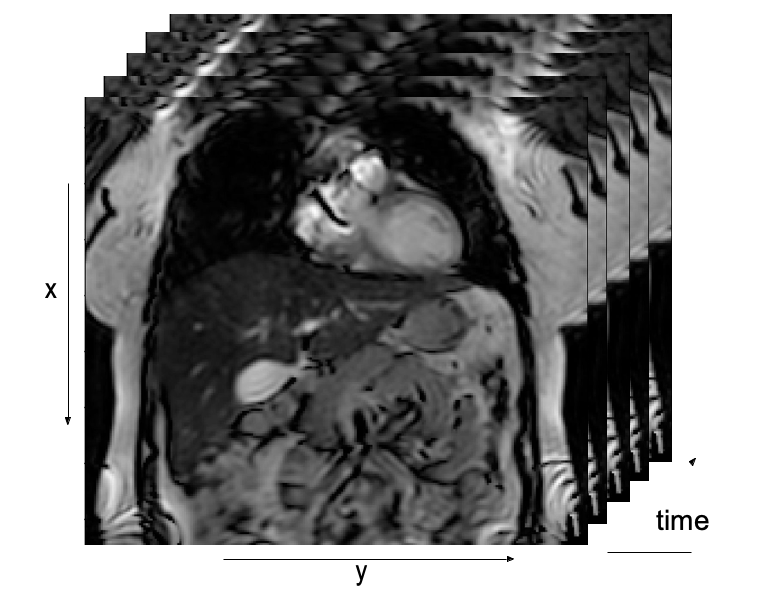

<font size=6 color=#009999> 3. Implementation </font> <br> <br>

<div class="alert alert-info">
<b>QUESTION 1</b>  <br>
What is the heartbeat frequency of the patient in beats/minutes.

In [1]:
#In this first part of the code, we will try to program a tool allowing us to determine where the patient's heart is.
#To do this, we will start by subtracting the frames of the video in order to determine the most moving areas over time.
#We are then going to take the pixel that moves the most on each frame.
#We then use a statistical method to exclude outliers, moving points not included in the heart.
#We finally average the variations of the pixels in the heart and do the fourier transform in order to obtain the heartbeat frequency.
#In this first part of the code, we will try to program a tool allowing us to determine where the patient's heart is.
#To do this, we will start by subtracting the frames of the video in order to determine the most moving areas over time.
#We are then going to take the pixel that moves the most on each frame.
#We then use a statistical method to exclude outliers, moving points not included in the heart.
#We finally average the variations of the pixels in the heart and do the fourier transform in order to obtain the heartbeat frequency.

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

heartBeatVidFilePath = 'heartVideo.npy'
video = np.load(heartBeatVidFilePath)
fps = 20

XandY_dim = video[0].shape
height = XandY_dim[1]
width = XandY_dim[0]
time_dim = video.shape[0]

#creation of the empty matrices
delta_pixels = np.zeros(video.shape)
sumFrame = np.zeros(XandY_dim)
t_max_delta_pixels = np.zeros((time_dim,2))

#technique constructed to use argmax
def idx(i, ncol):
    irow = i // ncol
    icol = i%ncol
    return [irow, icol]

#soustraction of frames to find moving areas
for t in range(1, time_dim):
        delta_pixels[t] = video[t] - video[t-1]
        t_max_delta_pixels[t-1][:] = idx(np.argmax(delta_pixels[t]), width) #put the max of each frame in a list
        sumFrame += video[t] - video[t-1] #total sum of moving pixels

#remove outliers located outside a circle of radius 90% of the half-width of the image
t_max_delta_pixels_norm = t_max_delta_pixels - (video.shape[1]/2)  #change of marker towards the center
for i in range(0, len(t_max_delta_pixels_norm)):
    if norm(t_max_delta_pixels_norm[i],2) > ((video.shape[1]/2) - ((video.shape[1]*10)/(2*100))):
        t_max_delta_pixels_norm[i] = [0,0] #transform the outliders into (0,0) to not interact with the mean
    else :
        t_max_delta_pixels_norm[i] = t_max_delta_pixels_norm[i]
t_max_delta_pixels = t_max_delta_pixels_norm + (video.shape[1]/2) #back to original marker

#variance technique to remove residuals outliers
mean_delta_pixels = np.mean(t_max_delta_pixels, axis = 0)
dist = abs(t_max_delta_pixels - mean_delta_pixels)
var = np.mean(dist, axis = 0)
tolerance_x = np.where(dist[:,0] > (var[0]))
tolerance_y = np.where(dist[:,1] > (var[1]))
zip_tolerance_x_y = list(zip(tolerance_x, tolerance_y))
flatten_list = []
for i in zip_tolerance_x_y[0][0]:
    flatten_list.append(i)
for j in zip_tolerance_x_y[0][1]:
    flatten_list.append(j)

outliers = list(set(flatten_list))

#final positions of the pixels of the heart without ouliers
y = np.delete(t_max_delta_pixels[:, 0], outliers)
x = np.delete(t_max_delta_pixels[:, 1], outliers)

#creation of a vector that contains the average variations of gray in the heart for each frame
#it is a kind of mean filter to improve image and calcul quality
pixels_heart = np.zeros((time_dim,len(x)))
for idx,idy,i in zip(x,y,range(len(x))):
    pixels_heart[:,i] = video[:,int(np.round(idy)),int(np.round(idx))]
mean_pixels_heart = np.zeros(time_dim)
for i in range(time_dim):
    mean_pixels_heart[i] = np.mean(pixels_heart[i,:])

fourier_transform = np.fft.fft(mean_pixels_heart)
fourier_transform = fourier_transform[1:len(fourier_transform)]

#graph
#plt.figure()
#plt.imshow(sumFrame, cmap ='gray') #subtraction of frames to illustrate, in dark, the most moving areas
#plt.scatter(x, y, color ='green') #heart points
#plt.scatter(idx, idy, color ='red') #central point of the heart
#plt.plot(fourier_transform) #fourier transform
#plt.show()

#detection of the heartbeat frequency by detection of the peak in the fourier transform
mean = (np.mean(fourier_transform)).real
dist_from_mean = np.zeros(len(fourier_transform))
for i in range(len(fourier_transform)):
    dist_from_mean[i] = abs(round(fourier_transform[i].real)-mean)
result = np.where(dist_from_mean == max(dist_from_mean))
frames_by_beat = result[0][0]+1
bpm = fps*60 / frames_by_beat
print("The heartbeat frequency of the patient is", bpm,"beats/minutes.")

The heartbeat frequency of the patient is 60.0 beats/minutes.


<div class="alert alert-info">
<b>QUESTION 2</b>  <br>
Explain how you found this result, and show a graph of the Fourier domain.

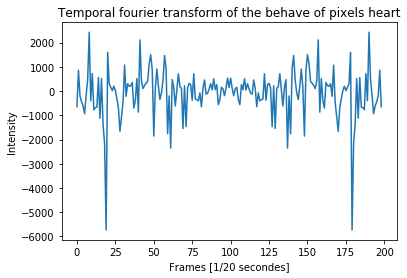

In [18]:
plt.figure()
plt.plot(fourier_transform)
plt.xlabel("Frames [1/20 secondes]")
plt.ylabel("Intensity")
plt.title("Temporal fourier transform of the behave of pixels heart")
plt.show()

The code is made of four different sections: finding the points belonging to the heart, removing the outliers, creating a vector that contains the average variations of gray in the heart for each frame and finally, using the Fourier transform to find the bmp. Let's understand each section individually, beginning with the section related to finding the points belonging to the heart. The method we used is looking at the pixel that has the most variation in each frame. That returns us 200 pixels. Unfortunately, some pixels do not belong to the heart. That leads us to the second section: removing the outliers. By intrinsic use of a MRI, the heart cannot be at the edges, that allowed us to remove the edges of the image and the outliers in it. For the outliers lying somewhere else, we used a simple method that removes the pixels lying at a certain distance of the mean of the pixels. Once we have our bunch of pixels belonging to the heart, we do the average of gray for each frame over our pixels of the heart. That returns us a vector of length 200, with the average gray colour of the heart at each frame. That's the vector we use to implement our Fourier transform. Finally, we can identify the most variation in the Fourier transform, and make a transformation of the x axis to get the frequency. 

<div class="alert alert-info">
<b>QUESTION 3</b>  <br>
How could you use the Fourier transform in the spatial dimension to pre-process your images and help you find the heartbeat frequency?

We can use the fourier transform in the spatial dimension to filter frames. Spatial filtering is a method for selecting
spatial components of an image but, unlike temporal filtering, we are not interested in temporal frequencies (colors)
but in spatial frequencies (shape of the image). This digital processing is used to improve the appearance of an
image or to highlight some of its main characteristics. Spatial filters are designed to enhance or dampen specific
features in an image based on their spatial frequency. Effective filters would have been the mean filter, the Gaussian
filters or the median filter. These would allow us to reduce noise and blur the image. Blurring is a pre-processing step for small detail removal and noise reduction is achieved by blurring. Thus, our fourier transform would have been less expensive in terms of computer calculation. For example, the average filter calculates the average of the pixels of an image and replaces it with the average of the levels of gray in the neighborhood defined by the mask of the filter.